# Performances

## Fitting

Optimal fitting refers to the balance between underfitting and overfitting in a model. It is crucial to achieve a model that generalizes well to new data.



### Underfitting

Underfitting occurs when a model is too simple to capture the underlying patterns in the data. This results in poor performance on both the training and validation datasets.

#### Characteristics of Underfitting:
- High bias
- Low variance
- Poor performance on training data
- Poor performance on validation data

#### Solutions to Underfitting:
- Increase model complexity
- Use more features
- Reduce regularization

### Optimal Fitting

Optimal fitting is achieved when a model performs well on both training and validation datasets, indicating good generalization.

#### Characteristics of Optimal Fitting:
- Balanced bias and variance
- Good performance on training data
- Good performance on validation data

#### Solutions to Achieve Optimal Fitting:
- Use cross-validation to tune hyperparameters
- Use ensemble methods
- Regularly evaluate model performance on validation data

### Overfitting

Overfitting occurs when the model learns not only the underlying patterns but also the noise in the training data, leading to poor generalization on unseen data.

#### Characteristics of Overfitting:
- Low bias
- High variance
- Excellent performance on training data
- Poor performance on validation data

#### Solutions to Overfitting:
- Use regularization techniques such as L1/L2 regularization
- Implement dropout
- Increase training data size
- Use early stopping

Underfit model  : Train MSE = 3.3061, Val MSE = 56.6842
Optimal model   : Train MSE = 0.2309, Val MSE = 4.4494
Overfit model   : Train MSE = 0.1435, Val MSE = 7.9622


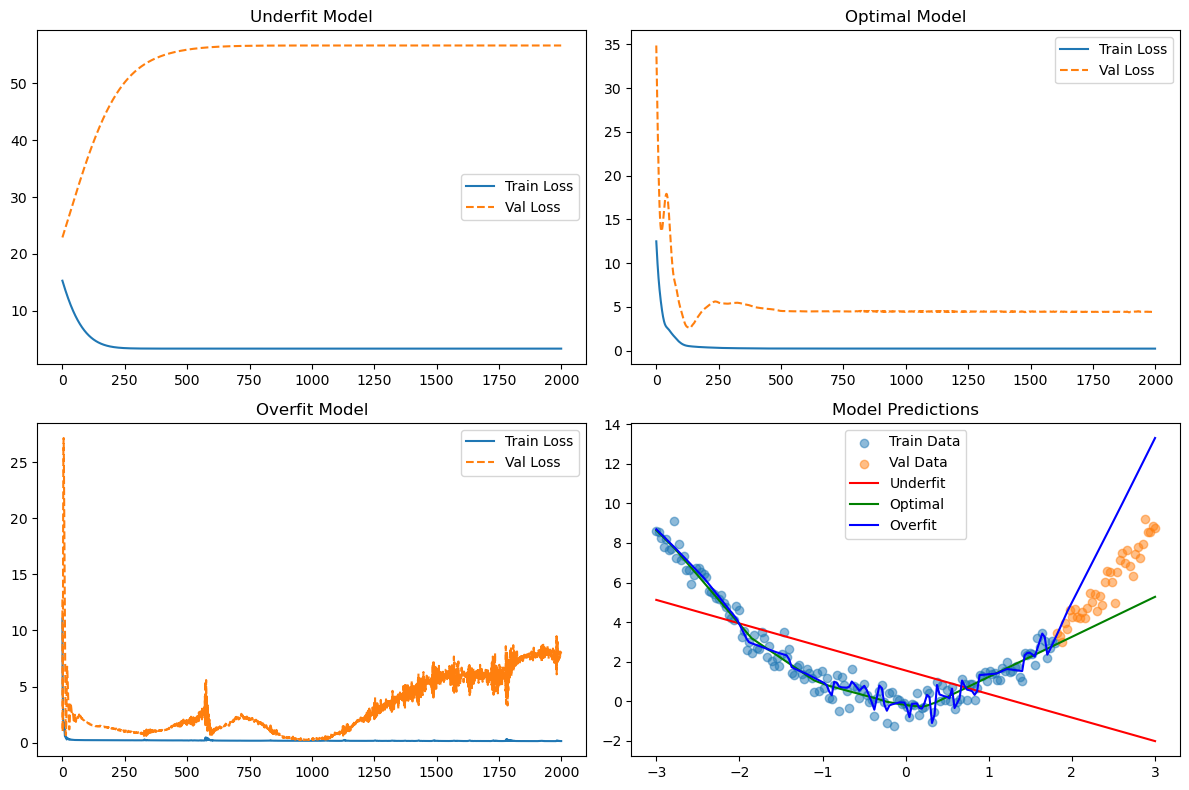

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1) Create synthetic dataset
# ---------------------------

torch.manual_seed(10)
N = 200
X = torch.linspace(-3, 3, N).unsqueeze(1)  # Shape: [N, 1]
y_true = X**2
noise = 0.5 * torch.randn_like(X)         
y = y_true + noise

train_size = int(0.8 * N)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


# -------------------------------
# 2) Define various model classes
# -------------------------------

class UnderfitNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

class OptimalNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class OverfitNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# ----------------------
# 3) Training function
# ----------------------

def train_model(model, X_tr, y_tr, X_vl, y_vl, epochs=1000, lr=1e-2):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_tr)
        loss = criterion(y_pred, y_tr)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_vl)
            val_loss = criterion(y_val_pred, y_vl)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    return train_losses, val_losses

def evaluate_model(model, X_data, y_data):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_data)
        mse = nn.functional.mse_loss(y_pred, y_data).item()
    return mse


# ------------------------
# 4) Train the three models
# ------------------------

model_underfit = UnderfitNet()
model_optimal = OptimalNet()
model_overfit = OverfitNet()

epochs = 2000
uf_train, uf_val = train_model(model_underfit, X_train, y_train, X_val, y_val, epochs)
opt_train, opt_val = train_model(model_optimal, X_train, y_train, X_val, y_val, epochs)
ov_train, ov_val = train_model(model_overfit, X_train, y_train, X_val, y_val, epochs)

print("Underfit model  : Train MSE = {:.4f}, Val MSE = {:.4f}"
      .format(evaluate_model(model_underfit, X_train, y_train),
              evaluate_model(model_underfit, X_val, y_val)))
print("Optimal model   : Train MSE = {:.4f}, Val MSE = {:.4f}"
      .format(evaluate_model(model_optimal, X_train, y_train),
              evaluate_model(model_optimal, X_val, y_val)))
print("Overfit model   : Train MSE = {:.4f}, Val MSE = {:.4f}"
      .format(evaluate_model(model_overfit, X_train, y_train),
              evaluate_model(model_overfit, X_val, y_val)))


# -----------------------------
# 5) Plot separate loss subplots
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Underfit losses
axs[0, 0].plot(uf_train, label='Train Loss')
axs[0, 0].plot(uf_val, label='Val Loss', linestyle='--')
axs[0, 0].set_title('Underfit Model')
axs[0, 0].legend()

# Optimal losses
axs[0, 1].plot(opt_train, label='Train Loss')
axs[0, 1].plot(opt_val, label='Val Loss', linestyle='--')
axs[0, 1].set_title('Optimal Model')
axs[0, 1].legend()

# Overfit losses
axs[1, 0].plot(ov_train, label='Train Loss')
axs[1, 0].plot(ov_val, label='Val Loss', linestyle='--')
axs[1, 0].set_title('Overfit Model')
axs[1, 0].legend()

# ------------------
# 6) Plot predictions
# ------------------
X_plot = torch.linspace(-3, 3, 200).unsqueeze(1)
with torch.no_grad():
    y_uf = model_underfit(X_plot)
    y_opt = model_optimal(X_plot)
    y_ov = model_overfit(X_plot)

axs[1, 1].scatter(X_train.numpy(), y_train.numpy(), label='Train Data', alpha=0.5)
axs[1, 1].scatter(X_val.numpy(), y_val.numpy(), label='Val Data', alpha=0.5)
axs[1, 1].plot(X_plot.numpy(), y_uf.numpy(), label='Underfit', color='r')
axs[1, 1].plot(X_plot.numpy(), y_opt.numpy(), label='Optimal', color='g')
axs[1, 1].plot(X_plot.numpy(), y_ov.numpy(), label='Overfit', color='b')
axs[1, 1].legend()
axs[1, 1].set_title('Model Predictions')

plt.tight_layout()
plt.show()


## Gradient Exploding

The gradient exploding problem occurs when gradients become very large during backpropagation, causing the weights to update excessively and destabilize the training process. This is another common issue in deep neural networks.

#### Causes of Gradient Exploding:
- Poor initialization of weights
- High learning rates
- Deep networks with many layers

#### Solutions to Gradient Exploding:
- Use gradient clipping to limit the size of gradients
- Use proper weight initialization techniques
- Use architectures like residual networks (ResNets)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# For reproducibility
torch.manual_seed(100)

# ----------------------
# 1) Define LSTM model
# ----------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        out, (h_n, c_n) = self.lstm(x)
        # Take the output at the final time step
        out = out[:, -1, :]  # shape: (batch_size, hidden_size)
        out = self.fc(out)
        return out

# ----------------------------
# 2) Generate random long data
# ----------------------------
sequence_length = 200   # Large sequence length to exacerbate exploding grads
batch_size = 10
input_size = 64
hidden_size = 128       # Large hidden layer
num_classes = 2

X = torch.randn(batch_size, sequence_length, input_size)  # Random input
y = torch.randint(0, num_classes, (batch_size,))          # Random labels

# -----------------------
# 3) Instantiate the model
# -----------------------
model = LSTMClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()

# NOTE: Extremely large learning rate to induce gradient explosion
learning_rate = 10.0
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# -----------------
# 4) Training loop
# -----------------
num_epochs = 10
grad_norm_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    
    loss.backward()
    
    # Calculate and record the total gradient norm
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    grad_norm_history.append(total_norm)

    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {loss.item():.4f} | Grad Norm: {total_norm:.4f}")

# --------------------------
# 5) Check final observations
# --------------------------
# Over several epochs, you may see the gradient norm become very large
# or even the loss jump to NaN if it overflows.


Epoch [1/10] Loss: 0.6930 | Grad Norm: 0.4069
Epoch [2/10] Loss: 0.1307 | Grad Norm: 0.5146
Epoch [3/10] Loss: 0.6485 | Grad Norm: 2.7655
Epoch [4/10] Loss: 6.7665 | Grad Norm: 3.8049
Epoch [5/10] Loss: 14.8679 | Grad Norm: 5.8872
Epoch [6/10] Loss: 5.1739 | Grad Norm: 7.1485
Epoch [7/10] Loss: 7.6690 | Grad Norm: 10.8009
Epoch [8/10] Loss: 5.0468 | Grad Norm: 9.4409
Epoch [9/10] Loss: 0.0000 | Grad Norm: 0.0000
Epoch [10/10] Loss: 0.0000 | Grad Norm: 0.0000


## Vanishing Gradient

The vanishing gradient problem occurs when gradients become very small during backpropagation, causing the weights to update very slowly and hindering the training process. This is a common issue in deep neural networks.

#### Causes of Vanishing Gradient:
- Poor initialization of weights
- Activation functions like sigmoid or tanh
- Deep networks with many layers

#### Solutions to Vanishing Gradient:
- Use ReLU or its variants as activation functions
- Use proper weight initialization techniques
- Use architectures like LSTM or GRU for recurrent neural networks

### Regularization Techniques

Regularization techniques are used to prevent overfitting and improve the generalization of the model. Some common regularization techniques include:

### L1 Regularization (Lasso)

L1 regularization adds a penalty equal to the absolute value of the magnitude of coefficients. It can lead to sparse models where some feature weights are exactly zero.

### L2 Regularization (Ridge)

L2 regularization adds a penalty equal to the square of the magnitude of coefficients. It encourages smaller weights but does not lead to sparse models.

### Dropout

Dropout is a regularization technique where randomly selected neurons are ignored during training. This prevents the model from becoming too reliant on any particular neuron and promotes the development of redundant representations.

### Early Stopping

Early stopping involves monitoring the model's performance on a validation set and stopping training when performance stops improving. This prevents the model from overfitting to the training data.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------
# 1) Set seeds for reproducibility
# -----------------------
torch.manual_seed(0)

# -----------------------
# 2) Generate random data
# -----------------------
N = 256        # Number of samples
input_dim = 20 # Input feature dimension
num_classes = 2

X = torch.randn(N, input_dim)                # Random features
y = torch.randint(0, num_classes, (N,))      # Random labels (binary classification)

# --------------------------------------------
# 3) Define a deep network with Sigmoid layers
# --------------------------------------------
class DeepSigmoidNet(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, depth=10, output_dim=2):
        """
        :param input_dim: dimension of the input
        :param hidden_dim: number of units per hidden layer
        :param depth: number of hidden layers
        :param output_dim: dimension of the output (for classification, = num_classes)
        """
        super().__init__()
        layers = []
        in_dim = input_dim
        for _ in range(depth):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.Sigmoid())
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --------------------
# 4) Instantiate model
# --------------------
model = DeepSigmoidNet(input_dim=20, hidden_dim=64, depth=10, output_dim=num_classes)
criterion = nn.CrossEntropyLoss()

# Small enough LR to avoid exploding gradients, but deep Sigmoid can vanish
optimizer = optim.SGD(model.parameters(), lr=0.01)

# -----------------
# 5) Training loop
# -----------------
num_epochs = 30
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass
    loss.backward()

    # Calculate total gradient norm
    total_grad_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_grad_norm += param_norm.item()**2
    total_grad_norm = total_grad_norm**0.5

    # Update parameters
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Grad Norm: {total_grad_norm:.4e}")


Epoch 1/30, Loss: 0.6935, Grad Norm: 8.9634e-02
Epoch 2/30, Loss: 0.6934, Grad Norm: 8.1789e-02
Epoch 3/30, Loss: 0.6933, Grad Norm: 7.4630e-02
Epoch 4/30, Loss: 0.6933, Grad Norm: 6.8097e-02
Epoch 5/30, Loss: 0.6932, Grad Norm: 6.2136e-02
Epoch 6/30, Loss: 0.6932, Grad Norm: 5.6697e-02
Epoch 7/30, Loss: 0.6932, Grad Norm: 5.1734e-02
Epoch 8/30, Loss: 0.6932, Grad Norm: 4.7205e-02
Epoch 9/30, Loss: 0.6931, Grad Norm: 4.3072e-02
Epoch 10/30, Loss: 0.6931, Grad Norm: 3.9302e-02
Epoch 11/30, Loss: 0.6931, Grad Norm: 3.5861e-02
Epoch 12/30, Loss: 0.6931, Grad Norm: 3.2722e-02
Epoch 13/30, Loss: 0.6931, Grad Norm: 2.9857e-02
Epoch 14/30, Loss: 0.6931, Grad Norm: 2.7244e-02
Epoch 15/30, Loss: 0.6931, Grad Norm: 2.4859e-02
Epoch 16/30, Loss: 0.6931, Grad Norm: 2.2683e-02
Epoch 17/30, Loss: 0.6930, Grad Norm: 2.0697e-02
Epoch 18/30, Loss: 0.6930, Grad Norm: 1.8886e-02
Epoch 19/30, Loss: 0.6930, Grad Norm: 1.7232e-02
Epoch 20/30, Loss: 0.6930, Grad Norm: 1.5724e-02
Epoch 21/30, Loss: 0.6930, Gr